# Price prediction with LSTM neural networks

Throughout this notebook, I will review the steps I've done to implement a recurrent neural network, based on LSTM cells, to predict the price of a forex pair, in this case in the euro-dollar pair, although It could have been any other.

For this, I made use of the TA-Lib library that provides different technical indicators such as MACD, RSI, CCI, etc ...


## 1 What to predict?

The main goal of the model to be implemented, is to estimate the HIGH and LOW prices of the next session (we use candles from H4 timeframe, so each session corresponds to 4 hours period), just by using last 4 session data (last four H4 data), received from the electronic trading platform, which include:

- OHLC prices
- Various technical indicators applied to these prices

Based on that range where price can move during next 4 hours, the intelligent Agent can perform long and short open-close operations to maximize profit along that range. Nevertheless, this is outside the scope of this notebook and will be addressed later on, when talking about the intelligent investment system based on the A3C-LSTM Agent.

## 2 Data preparation

Let's start to get a historic data from the EURUSD forex pair in H4 timeframe.

### Library loading

Here are most common libraries used:

- Numpy, Pandas, Scikit-Learn, Matplotlib & Seaborn
- Keras as frontend over Tensorflow
- Talib as technical indicators library
- MyUtils, own utility library developed ad-hoc for this project. Includes: several LSTM implementations, data partitioning, visualization, data backup, and more.


In [1]:
# Append path for MyUtils libraries
import sys
sys.path.append('../..')

####################################################################################
# Data handling 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls

####################################################################################
# TA-Lib: 
import talib

####################################################################################
# Other utilities
import datetime
import time
import os
import sys
import math

Using TensorFlow backend.


In [2]:
import common.MyUtils as utils
print('Ready!')

Ready!


### Historical OHLC data loading

In order to carry out the implementation of the model, we need a source of historical data with the OHLC prices of the euro-dollar pair.

The following file has been extracted from Metatrader and in particular from the Darwinex broker. It contains data from 2000 to 2018.

It is important to keep the following in mind when loading the historical data in the working dataframe, since you have to 'clean' them:

- Since we work with time data, we have to reindex the working dataframe so that each record has an exact 4-hour cadence. This will allow us to discover all missing data (NaNs). For example, in Forex, there is no quote during weekend and therefore all that data is absent.
- Apart from the hours in which there is no quote, it may be the case that the broker loses some records, for some technical reason. In that case you have to study missing data and fill it in the best possible way.
- It is also necessary to visualize the data to verify that there are no erroneous data, that alter the reality. If they exist, they must be corrected.

To carry out the previous 'cleaning', in my library 'MyUtils' I have the function 'load_hist' that allows to eliminate entries relative to weekends and makes a filling of the missing data type 'fillna' with the last known quote.


In [4]:
# Load and visualize hist-data
df = utils.load_hist('../csv_data/EURUSD_H4.csv', freq='4H', sep=';', remove_weekends=True)
df.head()


Deleting weekends...


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2000-01-03 04:00:00,1.0173,1.0181,1.0154,1.0157,1.01650,1.016400,1.016625,-0.0018,240,0,609.0,0.0,50.0
2000-01-03 08:00:00,1.0154,1.0167,1.0093,1.0115,1.01345,1.012500,1.013225,-0.0042,480,0,1731.0,0.0,50.0
2000-01-03 12:00:00,1.0118,1.0118,1.0054,1.0073,1.00955,1.008167,1.009075,-0.0042,720,0,1562.0,0.0,50.0
2000-01-03 16:00:00,1.0077,1.0240,1.0070,1.0218,1.01475,1.017600,1.015125,0.0145,960,0,1484.0,0.0,50.0
2000-01-03 20:00:00,1.0218,1.0278,1.0213,1.0246,1.02320,1.024567,1.023875,0.0028,1200,0,586.0,0.0,50.0


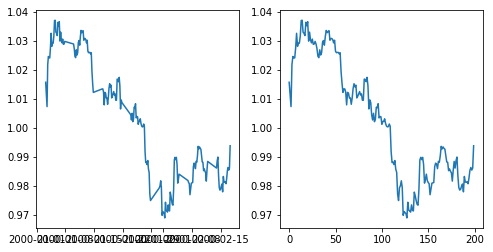

In [5]:
# Visualization range
i,j = 0,200
# Visualize range [i:j] of CLOSE price:
# Using x axis as dates at 1-hour pace
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df.CLOSE[0:200])
# Using continuous data
plt.subplot(1,2,2)
plt.plot(df.CLOSE.values[0:200])
# Both are valid

### Technical indicators

Once I've loaded OHLC price data in 'df' dataframe, I will generate several technical indicators. I use function 'add_indicators' which is part of python file '../../common/MyUtils.py'.

These are loaded indicators:

- Apart from OHLC prices I also add these ones: OC2=(O+C/2), HLC3=(O+H+L/3) and OHLC4=(O+H+L+C/4).
- BB (BollingerBands) applied to H (high) and L (low) and a pair of sinthetic indicators build from this one, as: BBWidth (bollinger bands width), BBWSMA4, BBWSMA12 which are 4 and 12 periods SMA of BBWidth indicator.
- BB %R, price position relative to its position inside the bollinger band.
- SMA4, SMA16, SMA40: 4,16 and 40 period SMA applied to H and L
- MACD with default configuration 12,26,9 applied to H and L
- RSI (14 periods) applied to H,L.
- APO (absolute price oscillator)
- MOM (momentum oscillator)
- ROCP,ROCR (rate of change price)
- Williams %R
- ATR y and two SMA (4 and 12 periods) applied to this one: ATR_SMA4, ATR_SMA12
- ADX, ADXR
- CCI
- STOCH (stochastic oscillator)

In [6]:
# Load technical indicators in df dataframe
df = utils.add_indicators(df, applied=['HIGH','LOW'], base_cols=['OPEN','HIGH','LOW','CLOSE','OC2','HLC3','OHLC4'])
# check columns
print(df.columns)
df.head(1)

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'OC2', 'HLC3', 'OHLC4',
       'IND_BB_UPPER_HIGH', 'IND_BB_MIDDLE_HIGH', 'IND_BB_LOWER_HIGH',
       'IND_BB_WIDTH_HIGH', 'IND_BB_PERCENT_HIGH', 'IND_BB_WIDTH_SMA4_HIGH',
       'IND_BB_WIDTH_SMA12_HIGH', 'IND_SMA4_HIGH', 'IND_SMA16_HIGH',
       'IND_SMA40_HIGH', 'IND_MACD_HIGH', 'IND_MACD_SIG_HIGH',
       'IND_MACD_HIST_HIGH', 'IND_RSI_HIGH', 'IND_APO_HIGH', 'IND_MOM_HIGH',
       'IND_ROCP_HIGH', 'IND_ROCR_HIGH', 'IND_BB_UPPER_LOW',
       'IND_BB_MIDDLE_LOW', 'IND_BB_LOWER_LOW', 'IND_BB_WIDTH_LOW',
       'IND_BB_PERCENT_LOW', 'IND_BB_WIDTH_SMA4_LOW', 'IND_BB_WIDTH_SMA12_LOW',
       'IND_SMA4_LOW', 'IND_SMA16_LOW', 'IND_SMA40_LOW', 'IND_MACD_LOW',
       'IND_MACD_SIG_LOW', 'IND_MACD_HIST_LOW', 'IND_RSI_LOW', 'IND_APO_LOW',
       'IND_MOM_LOW', 'IND_ROCP_LOW', 'IND_ROCR_LOW', 'IND_WILLR', 'IND_ATR',
       'IND_ATR_SMA4', 'IND_ATR_SMA12', 'IND_ADX', 'IND_ADXR', 'IND_CCI',
       'IND_SLOWK', 'IND_SLOWD'],
      dtype='object')


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ROCR_LOW,IND_WILLR,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD
2000-01-11 20:00:00,1.0315,1.0341,1.0309,1.0336,1.03255,1.032867,1.032525,1.036389,1.030785,1.025181,...,1.003602,-3.846154,0.004428,0.004448,0.004649,16.35667,22.545787,164.2718,75.337646,74.469078


### Predictions

As said, this model will predict an estimation of High and Low prices for next session. To achieve it, it will predict the price movement from the current close price. So, knowing the current close time and the prediction movement, it will extract the real High,Low prices.

So, both outputs could be expressed with these equations:

PREDICTION_HIGH(t+1) = PRICE_HIGH(t+1) - CLOSE(t)

PREDICTION_LOW(t+1) = PRICE_LOW(t+1) - CLOSE(t)


In [7]:
# function to generate predictions as explained above
def define_outputs(df):  
  df['OUT_HIGH'] = df.HIGH - df.CLOSE.shift(1)
  df['OUT_LOW'] = df.LOW - df.CLOSE.shift(1)
  return df

# Add both outputs to df dataframe and check first rows (also remove NaNs)
df = define_outputs(df)
df.dropna(inplace=True)
df.head()

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD,OUT_HIGH,OUT_LOW
2000-01-12 00:00:00,1.0337,1.0338,1.0319,1.0328,1.03325,1.032833,1.033050,1.035724,1.030635,1.025546,...,0.004247,0.004415,0.004580,16.228491,21.688298,140.692168,85.691181,77.171460,0.0002,-0.0017
2000-01-12 04:00:00,1.0329,1.0356,1.0323,1.0332,1.03305,1.033700,1.033500,1.036153,1.030745,1.025337,...,0.004179,0.004344,0.004520,16.560629,21.177927,133.670213,85.414828,82.147885,0.0028,-0.0005
2000-01-12 08:00:00,1.0331,1.0370,1.0321,1.0335,1.03330,1.034200,1.033925,1.036912,1.030935,1.024958,...,0.004231,0.004271,0.004463,17.198596,20.838957,117.197936,74.051192,81.719067,0.0038,-0.0011
2000-01-12 12:00:00,1.0328,1.0338,1.0275,1.0302,1.03150,1.030500,1.031075,1.037081,1.031005,1.024929,...,0.004379,0.004259,0.004426,16.257815,19.789314,30.303030,55.115785,71.527268,0.0003,-0.0060
2000-01-12 16:00:00,1.0303,1.0313,1.0261,1.0308,1.03055,1.029400,1.029625,1.037004,1.030955,1.024906,...,0.004437,0.004307,0.004397,15.203302,18.956971,-0.231080,43.922530,57.696502,0.0011,-0.0041


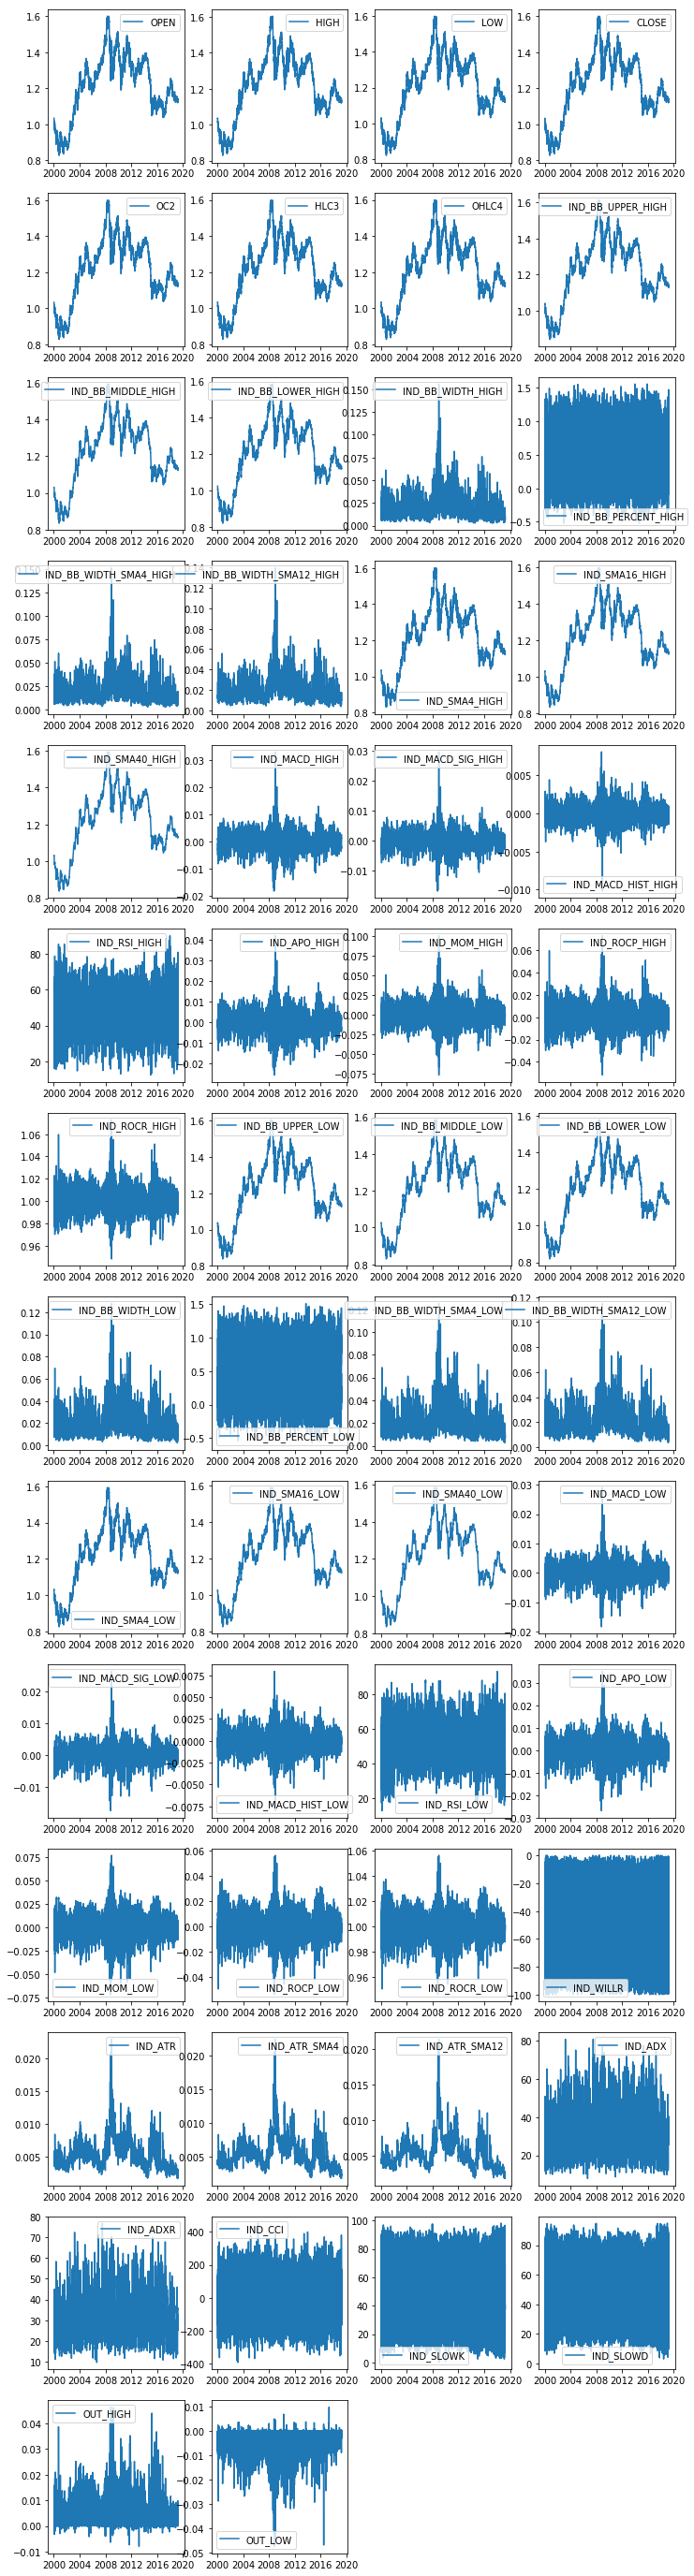

In [8]:
# Visualization of all columns: input features and target predictions
rows = (df.shape[1] / 4) + 1
plt.figure(figsize = (12,50))
for c in df.columns:
  i = df.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df[c])
  plt.legend([c])
  

### Data preprocessing

This model will predict price movement one timestep ahead, from a loopback window of the last 4 timesteps: 

(t-3), (t-2), (t-1), (t) ==> (t+1)

LSTM cells require input features and target outputs to be in a proper format:

- Input features shape: (num_samples, num_loopback_timesteps, num_input_features)
- Output target shape: (num_outputs * num_prediction_timesteps)

To adapt data contained in df dataframe into these sets, I use function 'series_to_supervised' contained in python file 'MyUtils.py'. You can check how it works there.


In [9]:
# Setup:

# Num outputs to predict
num_outputs = 2

# Num input features
num_inputs = len(df.columns) - num_outputs

# Num loopback timesteps
n_in = 4

# Num timesteps to predict
n_out = 1

# Flag to remove NaN values from  df dataframe
dropnan = True

# Run the preprocessor and get a new dataframe 'df_nn'
df_nn = utils.series_to_supervised(df, num_inputs, num_outputs, n_in, n_out, dropnan)

# Check the result
print(df_nn.shape)
df_nn.head()

(30077, 210)


,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2000-01-12 12:00:00,1.0337,1.0338,1.0319,1.0328,1.03325,1.032833,1.033050,1.035724,1.030635,1.025546,...,0.004379,0.004259,0.004426,16.257815,19.789314,30.303030,55.115785,71.527268,0.0011,-0.0041
2000-01-12 16:00:00,1.0329,1.0356,1.0323,1.0332,1.03305,1.033700,1.033500,1.036153,1.030745,1.025337,...,0.004437,0.004307,0.004397,15.203302,18.956971,-0.231080,43.922530,57.696502,0.0012,-0.0002
2000-01-12 20:00:00,1.0331,1.0370,1.0321,1.0335,1.03330,1.034200,1.033925,1.036912,1.030935,1.024958,...,0.004220,0.004317,0.004364,14.212057,17.807192,32.997988,38.219862,45.752726,0.0008,-0.0015
2000-01-13 00:00:00,1.0328,1.0338,1.0275,1.0302,1.03150,1.030500,1.031075,1.037081,1.031005,1.024929,...,0.004083,0.004280,0.004333,13.483285,16.835375,4.838710,41.896024,41.346139,0.0001,-0.0026
2000-01-13 04:00:00,1.0303,1.0313,1.0261,1.0308,1.03055,1.029400,1.029625,1.037004,1.030955,1.024906,...,0.003984,0.004181,0.004296,13.227618,16.143498,-49.816711,41.375750,40.497212,0.0015,-0.0012


In [10]:
# DATA DEBUGGING:
# Now I use an auxiliar temporal dataframe '_df' to check if target outputs are calculated correctly. I check if 'next_high' 
# column has the same content as 'HIGH(t)' shifted 1 timestemp in the future.
_df = df_nn[['HIGH(t-1)','HIGH(t)','LOW(t-1)','LOW(t)','CLOSE(t-1)', 'CLOSE(t)','OUT_HIGH(t+1)']].head(10).copy()
_df['next_high'] = _df['CLOSE(t)']+ _df['OUT_HIGH(t+1)']
_df

,HIGH(t-1),HIGH(t),LOW(t-1),LOW(t),CLOSE(t-1),CLOSE(t),OUT_HIGH(t+1),next_high
2000-01-12 12:00:00,1.0370,1.0338,1.0321,1.0275,1.0335,1.0302,0.0011,1.0313
2000-01-12 16:00:00,1.0338,1.0313,1.0275,1.0261,1.0302,1.0308,0.0012,1.0320
2000-01-12 20:00:00,1.0313,1.0320,1.0261,1.0306,1.0308,1.0308,0.0008,1.0316
2000-01-13 00:00:00,1.0320,1.0316,1.0306,1.0293,1.0308,1.0304,0.0001,1.0305
2000-01-13 04:00:00,1.0316,1.0305,1.0293,1.0278,1.0304,1.0293,0.0015,1.0308
2000-01-13 08:00:00,1.0305,1.0308,1.0278,1.0281,1.0293,1.0302,0.0003,1.0305
2000-01-13 12:00:00,1.0308,1.0305,1.0281,1.0237,1.0302,1.0264,0.0017,1.0281
2000-01-13 16:00:00,1.0305,1.0281,1.0237,1.0249,1.0264,1.0259,0.0006,1.0265
2000-01-13 20:00:00,1.0281,1.0265,1.0249,1.0252,1.0259,1.0260,0.0015,1.0275
2000-01-14 00:00:00,1.0265,1.0275,1.0252,1.0235,1.0260,1.0260,0.0010,1.0270


### Data normalization

A general preprocessing operation in Neural Networks is data normalization, in this case, as LSTM cells contains a 'tanh' cell, I will normalize all features in range [-1,+1].

I will save the scaler for further use when de-normalization process is required later on model validation. I use 'MinMaxScaler' from Scikit-learn library. For this purpose I use 'normalize_data' function from MyUtils.py file:

In [11]:
#### Data normalization. Get the scaler (save a copy on disk for later use) and a new normalized dataframe: dfnorm
dfnorm, scaler = utils.normalize_data(df_nn, feat_range = (-1,1), csv_to_save=None, scaler_to_save='../scaler_data/scaler.data')
# check result
dfnorm.describe()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
count,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,...,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000,30077.000000
mean,0.000814,0.000444,0.002346,0.000675,0.000292,0.000899,0.000813,-0.001463,0.004453,0.006084,...,-0.648267,-0.642172,-0.631434,-0.340196,-0.335242,-0.064530,0.019428,0.047042,-0.606692,0.565202
std,0.436670,0.435885,0.434624,0.436346,0.436688,0.437017,0.436950,0.442174,0.444014,0.439218,...,0.206882,0.211552,0.222424,0.344686,0.334898,0.261651,0.408644,0.384390,0.117525,0.112077
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.256104,-0.256524,-0.252486,-0.255938,-0.256201,-0.255811,-0.255635,-0.263575,-0.255804,-0.251938,...,-0.794121,-0.791734,-0.789251,-0.605398,-0.592700,-0.273100,-0.296763,-0.247662,-0.677087,0.537814
50%,0.050926,0.049768,0.053029,0.050712,0.050375,0.050732,0.050784,0.047456,0.055152,0.058455,...,-0.681161,-0.674758,-0.664490,-0.406761,-0.392158,-0.060789,0.019931,0.048562,-0.643987,0.600281
75%,0.315987,0.313950,0.316337,0.315679,0.315394,0.316115,0.315831,0.313793,0.322721,0.324202,...,-0.557059,-0.548446,-0.532970,-0.124761,-0.127989,0.141187,0.335739,0.341345,-0.581464,0.633971
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3 RNN model construction

First of all, I like to say that I will use Keras as fronted over Tensorflow, to build a stacked LSTM network.

I use function 'build_lstm_net' in MyUtils.py file (check it there if curious). It requires different arguments: num_inputs, num_outputs, loopback and predicted timestemps, number of LSTM layers, ...

In first place  I will execute a cross validation phase, using 'Kfolds' from Scikit-learn to get a first impression about the model. I'll generate 5 different models.


### Cross validation

dfnorm dataframe is used to get train-test in-out pairs. LSTM model is:

- 3 stacked LSTM layers with 64 neurons each.
- 1 Dense hidden layer with 128 neurons.
- 1 Dense output layer with 2 neurons (one per output)
- Dropout after each layer to improve generalization and avoid overfitting


In [12]:
# split into input (X) and output (Y) variables
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
# define 5-fold cross validation test harness
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
i=0
for train, test in kfold.split(X, Y):
  # create model
  model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'weights_0412_m'+str(i)+'.hd5')
  i += 1
  # Fit the model
  x = X[train]
  x = x.reshape(x.shape[0], n_in, num_inputs)
  utils.fit(model, x, Y[train], num_inputs, n_in, num_epochs=5, callbacks=callbacks, batchsize=32)  
  # evaluate the model
  x = X[test]
  scores = utils.test_evaluation(model, x, Y[test], num_inputs, n_in)
  x = x.reshape(x.shape[0], n_in, num_inputs)
  scores = model.evaluate(x, Y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

C:\Users\raulm\Programas\anaconda3\envs\keras\lib\site-packages\keras\callbacks.py:434: RuntimeWarning:

Can save best model only with val_acc available, skipping.



loss: 7.08%
acc: 99.90%
loss: 7.15%
acc: 99.92%
loss: 7.12%
acc: 99.92%
loss: 7.11%
acc: 99.97%
loss: 7.09%
acc: 99.83%
99.91% (+/- 0.04%)


As this model seems to be raise good results, I will train with a whole train-test dataset.

### Model training

In this case, I will use 'dfnorm' dataframe and get 80% (around 88000 samples) for training and 20% (around 22000 samples) for validation. I'll use 'prepare_training_data' and 'fit' functions from MyUtils.py file:

In [12]:
# Prepare data for train-test
x_train,y_train,x_test,y_test = utils.prepare_training_data(dfnorm, num_inputs * n_in, 0.8)
print('x_train:', x_train.shape, 'y_train', y_train.shape)
print('x_test:', x_test.shape, 'y_test', y_test.shape)


x_train: (24061, 208) y_train (24061, 2)
x_test: (6016, 208) y_test (6016, 2)


In [13]:
# Build the RNN model with same configuration
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'../hd5_data/weightsH4_3.2.64.128.hd5')

Train on 19248 samples, validate on 4813 samples
Epoch 1/30
 - 6s - loss: 0.0567 - acc: 0.9989 - val_loss: 0.0505 - val_acc: 0.9996
Epoch 2/30
 - 4s - loss: 0.0563 - acc: 0.9991 - val_loss: 0.0512 - val_acc: 0.9996
Epoch 3/30
 - 4s - loss: 0.0561 - acc: 0.9991 - val_loss: 0.0507 - val_acc: 0.9996
Epoch 4/30
 - 4s - loss: 0.0557 - acc: 0.9990 - val_loss: 0.0513 - val_acc: 0.9996
Epoch 5/30
 - 4s - loss: 0.0558 - acc: 0.9990 - val_loss: 0.0506 - val_acc: 0.9996
Epoch 6/30
 - 4s - loss: 0.0556 - acc: 0.9990 - val_loss: 0.0524 - val_acc: 0.9996
Epoch 7/30
 - 4s - loss: 0.0553 - acc: 0.9991 - val_loss: 0.0522 - val_acc: 0.9996
Epoch 8/30
 - 4s - loss: 0.0553 - acc: 0.9990 - val_loss: 0.0506 - val_acc: 0.9996
Epoch 9/30
 - 4s - loss: 0.0553 - acc: 0.9992 - val_loss: 0.0508 - val_acc: 0.9996
Epoch 10/30
 - 4s - loss: 0.0550 - acc: 0.9990 - val_loss: 0.0508 - val_acc: 0.9996
Epoch 11/30
 - 4s - loss: 0.0549 - acc: 0.9991 - val_loss: 0.0515 - val_acc: 0.9996
Epoch 12/30
 - 4s - loss: 0.0548 - a

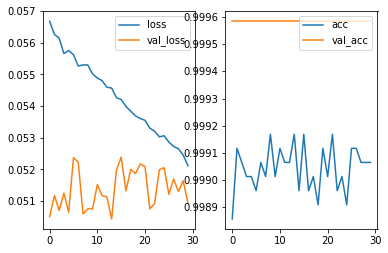

In [14]:
# Setup:

# Training epochs
num_epochs = 30
# Batch size
batchsize = 32
# Ratio validation-training (20%)
val_ratio = 0.2
# Enable data shuffling
shuffle = True
# Enable result plotting
plot_results = True
# Start training
result = utils.fit(model, x_train, y_train, num_inputs, n_in, num_epochs, callbacks, batchsize, val_ratio, shuffle, plot_results, verbose=2)

In [15]:
# Save model weights on disk, as HDF5 file
model.save_weights('../hd5_data/weightsH4_3.2.64.128.hd5')

### Model verification

Once trained, let's check its behaviour with new data. Function 'test_rmse' in MyUtils.py executes the test and returns the RMSE result. A callback 'out_builder' is needed to de-normalize data to calculate RMSE.

Model Loss:  0.04694709325570891
Model Accuracy:  0.9993351063829787


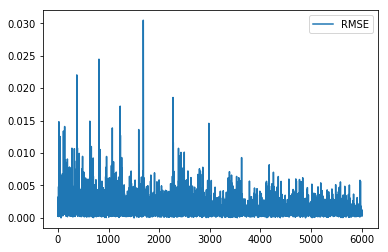

In [16]:
# column selection for 'out_builder' callback
ih = df_nn.columns.get_loc('OUT_HIGH(t+1)')  
il = df_nn.columns.get_loc('OUT_LOW(t+1)')
ic = df_nn.columns.get_loc('CLOSE(t)')
  
# Callback to build de-normalized output data from normalized predictions
def out_builder(xy,xyhat):
  return np.asarray([xy[ih]+xy[ic],xy[il]+xy[ic]]), np.asarray([xyhat[ih]+xyhat[ic],xyhat[il]+xyhat[ic]])
  
# Executes test process and visualizes RMSE result
scores, targets, preds, rmse = utils.test_rmse(model, x_test, y_test, num_inputs, n_in, num_outputs, n_out, scaler, out_builder, True)

In [20]:
# Dataframe update:

# Reshape results into np.arrays
atgt = np.asarray(targets)
apreds = np.asarray(preds)
armse = np.asarray(rmse)

# Build a new dataframe named 'df_predict' with prediction results.
df_predict = df_nn[x_train.shape[0]:].copy()
#... add predictions...
df_predict['PREDICT_HIGH'] = apreds[:,0]
df_predict['PREDICT_LOW'] = apreds[:,1]

#... add targets...
df_predict['TARGET_HIGH'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)'] 

#... add some data-debugging columns to validate results
df_predict['TARGET_HIGH_CHECK'] = atgt[:,0]
df_predict['TARGET_LOW_CHECK'] = atgt[:,1]

#... add RMSE error
df_predict['RMSE'] = armse[:]

# Visualize first rows for visual debugging
df_predict.head()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1),PREDICT_HIGH,PREDICT_LOW,TARGET_HIGH,TARGET_LOW,TARGET_HIGH_CHECK,TARGET_LOW_CHECK,RMSE
2015-05-27 16:00:00,1.08781,1.08914,1.08644,1.08882,1.088315,1.088133,1.088052,1.120801,1.101467,1.082133,...,57.193685,0.00255,-0.00058,1.089249,1.086063,1.09068,1.08755,1.09068,1.08755,0.001459
2015-05-27 20:00:00,1.08884,1.09284,1.08869,1.09192,1.090380,1.091150,1.090572,1.117562,1.100069,1.082575,...,51.316159,0.00553,-0.00364,1.092486,1.083670,1.09587,1.08670,1.09587,1.08670,0.003212
2015-05-28 00:00:00,1.09191,1.09240,1.08263,1.08309,1.087500,1.086040,1.087508,1.115270,1.098930,1.082590,...,55.788395,0.00104,-0.00187,1.092227,1.090163,1.09201,1.08910,1.09201,1.08910,0.000767
2015-05-28 04:00:00,1.08311,1.09098,1.08185,1.08813,1.085620,1.086987,1.086017,1.111858,1.097602,1.083345,...,61.823699,0.00330,-0.00160,1.095371,1.090082,1.09502,1.09012,1.09502,1.09012,0.000249
2015-05-28 08:00:00,1.08811,1.09068,1.08755,1.09034,1.089225,1.089523,1.089170,1.105960,1.096101,1.086242,...,70.446506,0.00058,-0.00642,1.094985,1.090367,1.09459,1.08759,1.09459,1.08759,0.001983


Now I carry on a visual inspection of results obtained. I can range the visualization plot to zoom in or out.

Target range (real range between high and low prices) is coloured in grey, while predicted range (area between predicted high and low) is coloured in yellow.

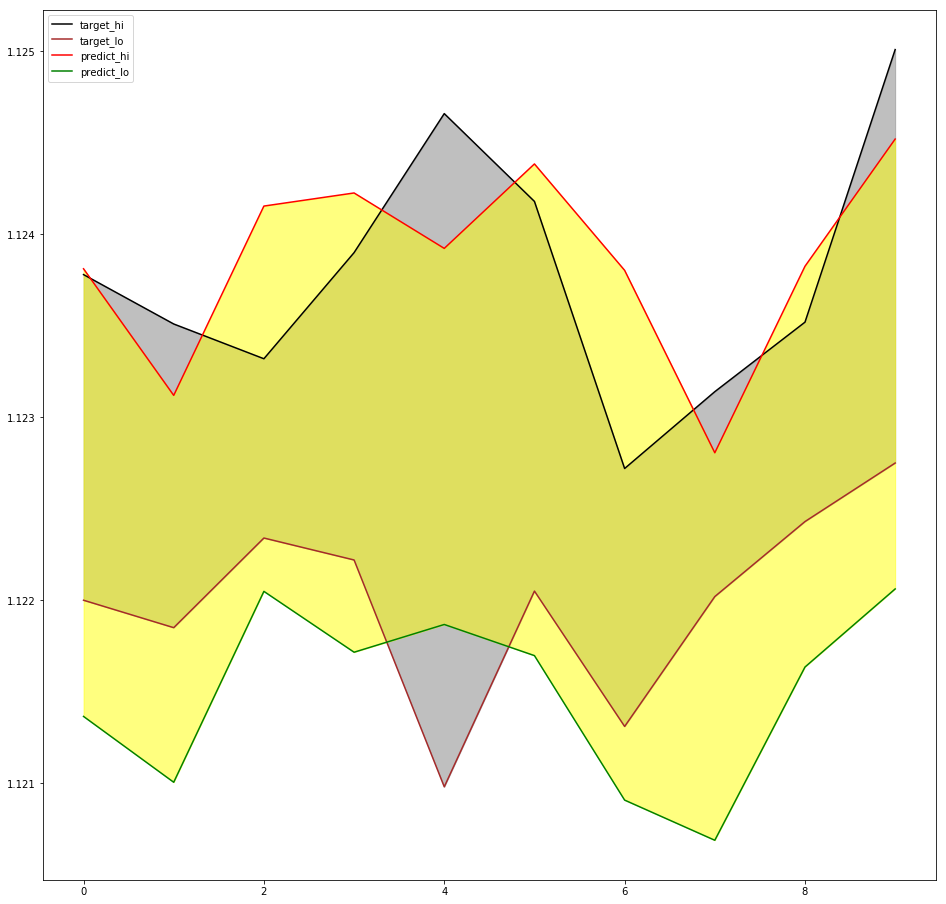

In [23]:
plt.figure(figsize=(16,16))
i=-10
x = np.arange(10)
y1 = df_predict['TARGET_HIGH'].values[i:]
y2 = df_predict['TARGET_LOW'].values[i:]
y3 = df_predict['PREDICT_HIGH'].values[i:]
y4 = df_predict['PREDICT_LOW'].values[i:]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])


As can be seen, there exist a small prediction error. In general, predicted range between High and Low prices as greater than real High-Low range.


### Next steps

Once verified that prediction is valid for my purposes, it's time to build a dataframe for the next stage: A3C-LSTM agent.

In this new stage, the agent will require real time market data (bars, quotes, account info and predictions) to start its training process as a RL problem.

Now we are going to build a dataframe (only with bars, targets, predictions) for this next stage:

In [24]:
# split historic data into input (X) and output (Y) variables and executes predictions
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
predictions = model.predict(X.reshape(X.shape[0], n_in, num_inputs), batch_size=1)

In [25]:
# let's copy dfnorm and add predictions as new columns
df_predict = dfnorm.copy()
df_predict['OUT_HIGH(t+1)'] = predictions[:,0]
df_predict['OUT_LOW(t+1)']  = predictions[:,1]
df_predict.tail()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2019-03-29 12:00:00,-0.235987,-0.238499,-0.227302,-0.232833,-0.234969,-0.233905,-0.234506,-0.240871,-0.227209,-0.214054,...,-0.943150,-0.948554,-0.948498,-0.161463,-0.269841,-0.225025,0.098564,-0.091853,-0.662198,0.607901
2019-03-29 16:00:00,-0.232854,-0.238989,-0.226037,-0.233325,-0.233649,-0.233810,-0.233651,-0.242258,-0.228431,-0.215090,...,-0.944199,-0.949459,-0.949656,-0.142329,-0.262989,-0.208327,0.132616,0.091985,-0.658946,0.603701
2019-03-29 20:00:00,-0.233346,-0.237494,-0.226346,-0.233325,-0.233894,-0.233413,-0.233476,-0.243727,-0.229485,-0.215708,...,-0.950007,-0.949559,-0.951364,-0.116938,-0.239912,-0.317499,-0.167390,0.048931,-0.668040,0.622314
2019-04-01 00:00:00,-0.233346,-0.235534,-0.229549,-0.232910,-0.233687,-0.233689,-0.233683,-0.245783,-0.230475,-0.215611,...,-0.955601,-0.950169,-0.952798,-0.106456,-0.225579,-0.203410,-0.235697,-0.067271,-0.669160,0.618697
2019-04-01 04:00:00,-0.232906,-0.236772,-0.226785,-0.234644,-0.234335,-0.233758,-0.233625,-0.247812,-0.231459,-0.215527,...,-0.962743,-0.955198,-0.954343,-0.108419,-0.218607,-0.104877,-0.067698,-0.136908,-0.666020,0.612274


In [26]:
# de-normalize data
df_predict = utils.denormalize_data(df_predict, scaler)
df_predict.tail()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2019-03-29 12:00:00,1.12200,1.12351,1.12185,1.12321,1.122605,1.122857,1.122643,1.133881,1.127986,1.122091,...,0.002286,0.002249,0.002322,38.453884,34.124031,-65.097511,53.900272,43.484375,0.001205,-0.001483
2019-03-29 16:00:00,1.12321,1.12332,1.12234,1.12302,1.123115,1.122893,1.122972,1.133347,1.127521,1.121695,...,0.002275,0.002240,0.002311,39.153080,34.355087,-58.036297,55.571014,52.133068,0.001293,-0.001603
2019-03-29 20:00:00,1.12302,1.12390,1.12222,1.12302,1.123020,1.123047,1.123040,1.132781,1.127120,1.121459,...,0.002213,0.002238,0.002294,40.080956,35.133255,-104.200996,40.851448,50.107574,0.001046,-0.001072
2019-04-01 00:00:00,1.12302,1.12466,1.12098,1.12318,1.123100,1.122940,1.122960,1.131990,1.126743,1.121496,...,0.002154,0.002232,0.002280,40.463993,35.616558,-55.957146,37.500000,44.640820,0.001016,-0.001175
2019-04-01 04:00:00,1.12319,1.12418,1.12205,1.12251,1.122850,1.122913,1.122983,1.131209,1.126369,1.121528,...,0.002078,0.002180,0.002265,40.392258,35.851639,-14.291349,45.742752,41.364735,0.001101,-0.001358


In [27]:
# Add new columns for expected targets
df_predict['TARGET_HIGH'] = df_nn['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_nn['OUT_LOW(t+1)'] 

#... calculate RMSE error between targets and predictions
df_predict['RMSE'] = df_predict.apply(lambda row: math.sqrt(sk.mean_squared_error(np.asarray([row['TARGET_HIGH'], row['TARGET_LOW']]), np.asarray([row['OUT_HIGH(t+1)'], row['OUT_LOW(t+1)']]), multioutput = 'uniform_average')), axis=1)

# add new columns to get targets and predictions as absolute price values
df_predict['PREDICT_HIGH_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)']
df_predict['PREDICT_LOW_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)']
df_predict['TARGET_HIGH_PRICE'] = df_predict['CLOSE(t)'] + df_predict['TARGET_HIGH']
df_predict['TARGET_LOW_PRICE'] = df_predict['CLOSE(t)'] + df_predict['TARGET_LOW']

#... and calculate RMSE error using absolute price values
df_predict['RMSE_PRICE'] = df_predict.apply(lambda row: math.sqrt(sk.mean_squared_error(np.asarray([row['TARGET_HIGH_PRICE'], row['TARGET_LOW_PRICE']]), np.asarray([row['PREDICT_HIGH_PRICE'], row['PREDICT_LOW_PRICE']]), multioutput = 'uniform_average')), axis=1)

df_predict.head()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,OUT_HIGH(t+1),OUT_LOW(t+1),TARGET_HIGH,TARGET_LOW,RMSE,PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE,TARGET_HIGH_PRICE,TARGET_LOW_PRICE,RMSE_PRICE
2000-01-12 12:00:00,1.0337,1.0338,1.0319,1.0328,1.03325,1.032833,1.033050,1.035724,1.030635,1.025546,...,0.001197,-0.002426,0.0011,-0.0041,0.001185,1.031397,1.027774,1.0313,1.0261,0.001185
2000-01-12 16:00:00,1.0329,1.0356,1.0323,1.0332,1.03305,1.033700,1.033500,1.036153,1.030745,1.025337,...,0.001003,-0.001290,0.0012,-0.0002,0.000784,1.031803,1.029510,1.0320,1.0306,0.000784
2000-01-12 20:00:00,1.0331,1.0370,1.0321,1.0335,1.03330,1.034200,1.033925,1.036912,1.030935,1.024958,...,0.000850,-0.001824,0.0008,-0.0015,0.000232,1.031650,1.028976,1.0316,1.0293,0.000232
2000-01-13 00:00:00,1.0328,1.0338,1.0275,1.0302,1.03150,1.030500,1.031075,1.037081,1.031005,1.024929,...,0.001008,-0.002385,0.0001,-0.0026,0.000660,1.031408,1.028015,1.0305,1.0278,0.000660
2000-01-13 04:00:00,1.0303,1.0313,1.0261,1.0308,1.03055,1.029400,1.029625,1.037004,1.030955,1.024906,...,0.002131,-0.000943,0.0015,-0.0012,0.000482,1.031431,1.028357,1.0308,1.0281,0.000482


In [28]:
# Select only required columns for next stage
df_predict = df_predict[['OPEN(t)','HIGH(t)','LOW(t)','CLOSE(t)','OUT_HIGH(t+1)','OUT_LOW(t+1)','TARGET_HIGH','TARGET_LOW','RMSE','PREDICT_HIGH_PRICE','PREDICT_LOW_PRICE','TARGET_HIGH_PRICE','TARGET_LOW_PRICE', 'RMSE_PRICE']]
df_predict.tail()                      

,OPEN(t),HIGH(t),LOW(t),CLOSE(t),OUT_HIGH(t+1),OUT_LOW(t+1),TARGET_HIGH,TARGET_LOW,RMSE,PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE,TARGET_HIGH_PRICE,TARGET_LOW_PRICE,RMSE_PRICE
2019-03-29 12:00:00,1.12302,1.12466,1.12098,1.12318,0.001205,-0.001483,0.00100,-0.00113,0.000289,1.124385,1.121697,1.12418,1.12205,0.000288
2019-03-29 16:00:00,1.12319,1.12418,1.12205,1.12251,0.001293,-0.001603,0.00021,-0.00120,0.000817,1.123803,1.120907,1.12272,1.12131,0.000817
2019-03-29 20:00:00,1.12251,1.12272,1.12131,1.12176,0.001046,-0.001072,0.00138,0.00026,0.000971,1.122806,1.120688,1.12314,1.12202,0.000971
2019-04-01 00:00:00,1.12255,1.12314,1.12202,1.12281,0.001016,-0.001175,0.00071,-0.00038,0.000602,1.123826,1.121635,1.12352,1.12243,0.000602
2019-04-01 04:00:00,1.12281,1.12352,1.12243,1.12342,0.001101,-0.001358,0.00159,-0.00067,0.000597,1.124521,1.122062,1.12501,1.12275,0.000597


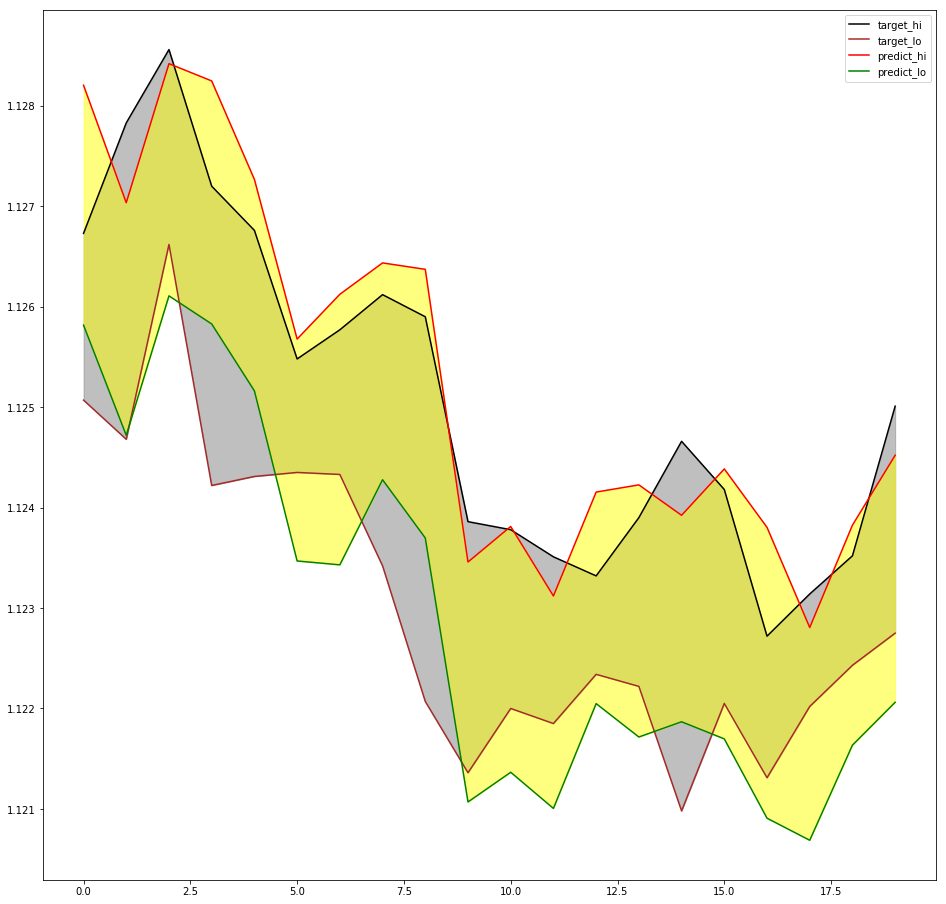

In [29]:
# Show targets (grey area) vs predictions (yellow area)
plt.figure(figsize=(16,16))
# Zoom in range to plot (can be changed)
i=-20
x = np.arange(-i)
y1 = df_predict['TARGET_HIGH_PRICE'].values[i:]
y2 = df_predict['TARGET_LOW_PRICE'].values[i:]
y3 = df_predict['PREDICT_HIGH_PRICE'].values[i:]
y4 = df_predict['PREDICT_LOW_PRICE'].values[i:]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])

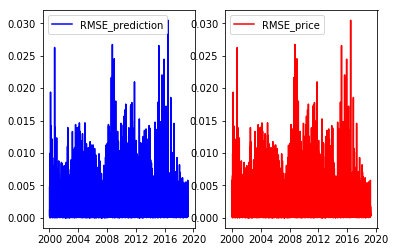

In [30]:
# Show RMSE errors
plt.subplot(1,2,1)
plt.plot(df_predict['RMSE'], color='b')
plt.legend(['RMSE_prediction'])
plt.subplot(1,2,2)
plt.plot(df_predict['RMSE_PRICE'], color = 'r')
plt.legend(['RMSE_price'])

In [31]:
# Save file on disk
df_predict.to_csv('../csv_data/EURUSD_H4_predictions.csv', sep=';')
print('File saved!')

File saved!
